In [1]:
import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
import tensorflow as tf
import tensorflow_hub as hub
import imageio
from google_images_download import google_images_download
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.filters import gaussian
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage import color, io
from skimage.exposure import rescale_intensity


Using TensorFlow backend.


In [2]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1")
height, width = hub.get_expected_image_size(module)
height, width

Instructions for updating:
Colocations handled automatically by placer.


W0821 08:52:24.279946 4506453440 deprecation.py:323] From /Users/lambda_school_loaner_153/anaconda3/envs/U4-S3-DNN/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


(224, 224)

In [3]:
response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal national park", "limit": 20,
             "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal national park
Evaluating...
Starting Download...
Image URL: https://i.ytimg.com/vi/P8NJa_YoRxk/maxresdefault.jpg
Completed Image ====> 1.maxresdefault.jpg
Image URL: https://k6u8v6y8.stackpathcdn.com/blog/wp-content/uploads/2017/06/Royal-Bengal-Tiger.jpg
Completed Image ====> 2.Royal-Bengal-Tiger.jpg
Image URL: https://www.nps.gov/arch/learn/nature/images/ARK_6.jpg?maxwidth=1200&maxheight=1200&autorotate=false
Completed Image ====> 3.ARK_6.jpg
Image URL: https://www.corbettnationalpark.in/blog/wp-content/uploads/2015/08/cropped-13625772024_1fd7467d29_k1.jpg
Completed Image ====> 4.cropped-13625772024_1fd7467d29_k1.jpg
Image URL: https://npca.s3.amazonaws.com/images/8135/2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg?1445969501
Completed Image ====> 5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg
Image URL: https://k6u8v6y8.stackpathcdn.com/blog/wp-content/uploads/2014/04/national-parks-and-wildlife-sanctuaries-in-india.png
Completed Image ====> 6.

In [4]:
image_list = absolute_image_paths[0]['animal national park']
image_list

['/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/1.maxresdefault.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/2.Royal-Bengal-Tiger.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/3.ARK_6.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/4.cropped-13625772024_1fd7467d29_k1.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal

In [5]:
def resize_image(filename, new_width=224, new_height=224):
    pil_image = Image.open(filename)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)
#     print(filename)
    return filename

In [6]:
images = [resize_image(image) for image in image_list]
images

['/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/1.maxresdefault.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/2.Royal-Bengal-Tiger.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/3.ARK_6.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/4.cropped-13625772024_1fd7467d29_k1.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal

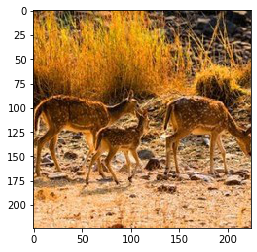

In [7]:
plt.imshow(np.asarray(Image.open(images[11])))

In [8]:
real_images = np.array([np.asarray(Image.open(image)) / 255 for image in images])
real_images.shape

(20, 224, 224, 3)

In [9]:
real_images.shape

(20, 224, 224, 3)

In [10]:
logits = module(real_images)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0821 08:52:44.962066 4506453440 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [11]:
target_map = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt').content

In [12]:
# str(target_map).split('\\n')

In [13]:
lookup = [target.strip() for target in str(target_map).split('\\n')]


In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    codes = []
    for i in range(20):
        codes.append(np.argmax(logits[i].eval()))

In [15]:
codes[5]

293

In [16]:
lookup[codes[5]]

'tiger'

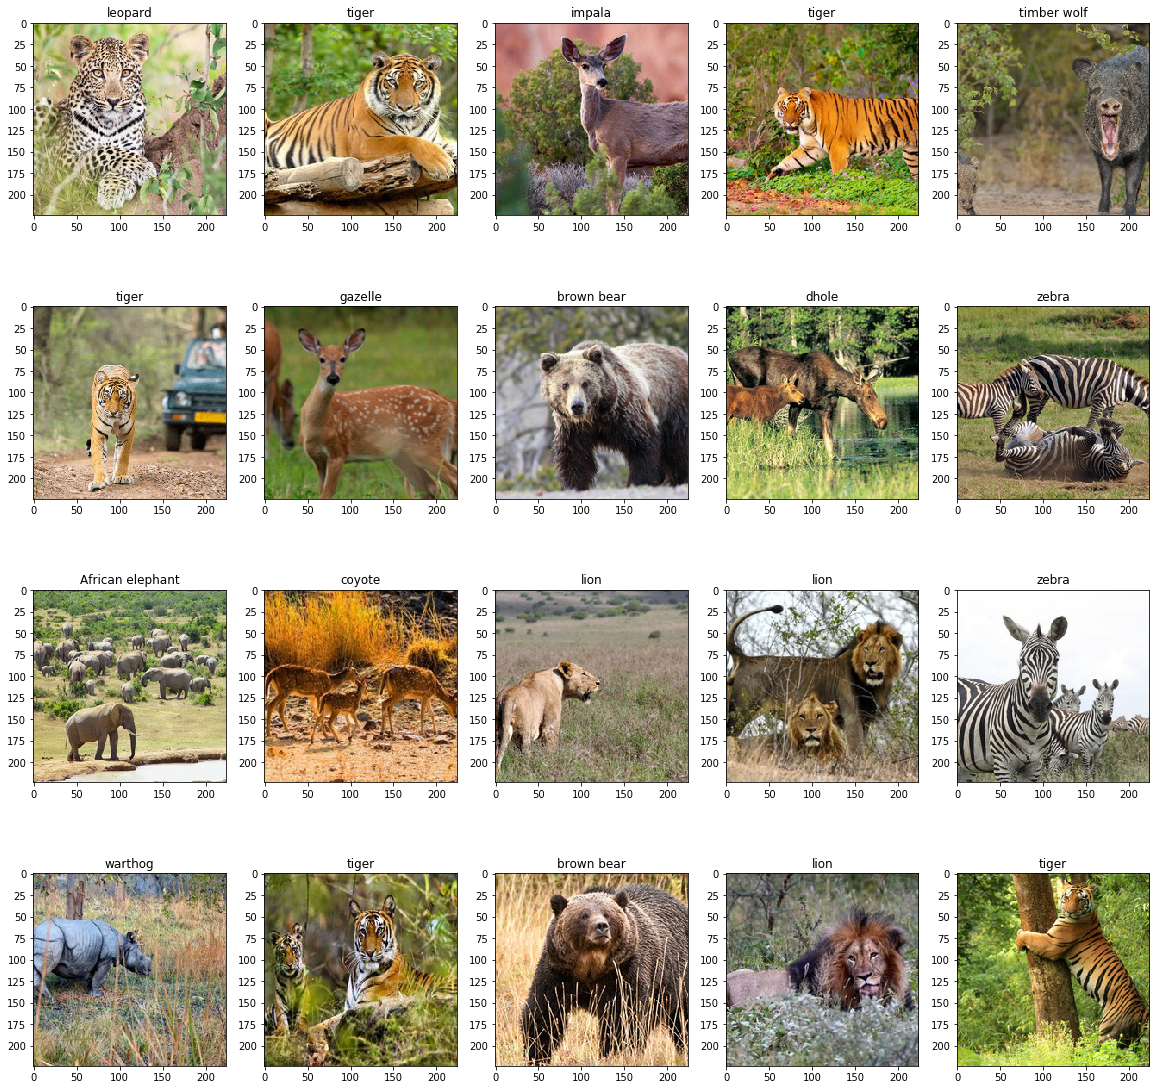

In [17]:
import math
cols = 5
rows = math.ceil(len(images)/5)
fig=plt.figure(figsize=(20, 20))
with tf.Session() as sess:
    for idx,image in enumerate(real_images):
        fig.add_subplot(rows, cols, idx+1)
        plt.imshow(image)
        plt.title(lookup[codes[idx]])
plt.savefig('animals.jpg', dpi=120)
plt.show()